In [1]:
from IPython.display import display
from openbb_terminal.sdk import openbb

import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

In [2]:
def ticker_to_yahoo_format(t):
    return '.'.join(t.split(':')[::-1])[:-1]

def get_daily_data_with_today(ticker, today, start_date=None, n_days=None, enforce_today=True, adj_div=True):
    if ticker[0] == 'H':
        ticker = ticker_to_yahoo_format(ticker)
    if start_date is None:
        start_date = today - (datetime.timedelta(days=n_days if n_days is not None else 365))
    data_until_today = openbb.stocks.load(
        ticker,
        interval=1440,
        start_date=start_date,
        verbose=False
    ).drop('Adj Close', axis=1)
    
    if enforce_today:
        data_today = openbb.stocks.load(
            ticker,
            interval=1,
            start_date=today - datetime.timedelta(days=1),
            end_date=today,
            verbose=False
        ).drop('Adj Close', axis=1)
        data_today = data_today[data_today.index.time != datetime.time(16, 8)]
        data_today = data_today.groupby(data_today.index.floor('1D')).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
        data_today = data_today[data_today.index.date == today.date()]
        if not len(data_today):
            raise ValueError('No minute data for today')
        data = pd.concat([data_until_today[data_until_today.index < today], data_today])
    else:
        data = data_until_today
    
    if adj_div:
        div_data = openbb.stocks.fa.divs(ticker)
        if div_data.empty:
            div_dct = {}
        else:
            div_data.drop('Change', axis=1, inplace=True)
            div_data.index = div_data.index.floor('1D').tz_localize(None)
            div_data['prev_Date'] = div_data.index - datetime.timedelta(days=1)
            merged_data = pd.merge_asof(div_data.sort_index().reset_index(), data[['Close']].reset_index(),
                                        direction='backward', left_on='prev_Date', right_on='date').dropna()
            merged_data['yield'] = merged_data['Dividends'] / merged_data['Close']
            if len(merged_data):
                div_dct = merged_data[['date', 'yield']].set_index('date')['yield'].to_dict()
            else:
                div_dct = {}
        for ex_date, yield_rate in sorted(div_dct.items()):
            data.loc[data.index <= ex_date, ['Open', 'High', 'Low', 'Close']] *= (1 - yield_rate)
    return data

def SMMA(s, n):
#     никто все равно так не считает, все берут ЕМА обычный
#     а раз все берут ЕМА, то и "самосбывающееся пророчество" по этому индикатору происходит по ЕМА
#     return s.rolling(n).mean().dropna().ewm(alpha=1/n).mean()
    return s.ewm(alpha=1/n).mean()

def RSI(data, n=14):
    d = data['Close']
    U = SMMA(np.maximum(data['Close'] - data['Close'].shift(1), 0).dropna(), n)
    D = SMMA(np.maximum(data['Close'].shift(1) - data['Close'], 0).dropna(), n)
    return 100 * U / (U + D + 1e-25)

In [3]:
green_tickers = """HKG:0388
HKG:3988
HKG:2331
HKG:0669
HKG:9988
HKG:2015
HKG:0857
HKG:0386
HKG:1088
HKG:1347
HKG:9999
HKG:1928
HKG:1109"""

blue_tickers = """HKG:0939
HKG:9866
HKG:9618
HKG:2688
HKG:0992
HKG:0268
HKG:2518
HKG:9888
HKG:9626
HKG:0700
HKG:1113"""

 17%|███████▎                                    | 4/24 [00:10<00:52,  2.63s/it]

No dividends found.

 21%|█████████▏                                  | 5/24 [00:12<00:46,  2.44s/it]

No dividends found.

 58%|█████████████████████████                  | 14/24 [00:41<00:27,  2.75s/it]

No dividends found.

 83%|███████████████████████████████████▊       | 20/24 [00:55<00:09,  2.36s/it]

No dividends found.

 88%|█████████████████████████████████████▋     | 21/24 [00:57<00:06,  2.29s/it]

No dividends found.

100%|███████████████████████████████████████████| 24/24 [01:06<00:00,  2.77s/it]


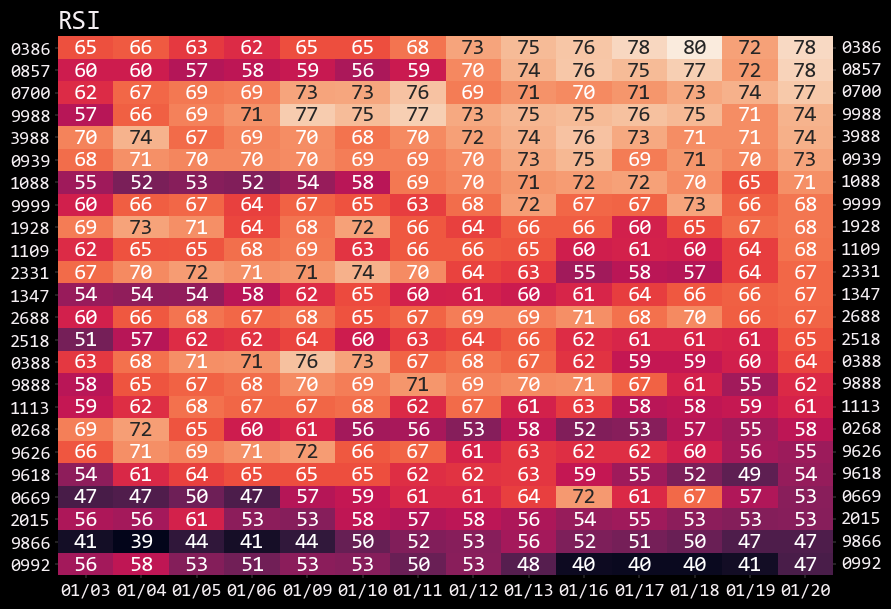

In [4]:
rsi_data = {}
for ticker in tqdm.tqdm((green_tickers + '\n' + blue_tickers).split('\n')):
    data = get_daily_data_with_today(ticker, datetime.datetime.combine(datetime.date.today(), datetime.time()), enforce_today=True)
    rsi_data[ticker] = RSI(data)
rsi_data = pd.DataFrame(rsi_data)
rsi_data.index = [str(x)[-5:].replace('-', '/') for x in rsi_data.index.date]
rsi_data.columns = [x[4:] for x in rsi_data.columns]

plt.figure(figsize=(10, 7))
ax = sns.heatmap(rsi_data.T.iloc[:, -14:].sort_values(rsi_data.index[-1], ascending=False), annot=True, cbar=False)
ax.tick_params(left=True, labelleft=True, right=True, labelright=True, rotation=0)
plt.title('RSI')
plt.show()

In [5]:
g8_tickers = """HKG:0001
HKG:0175
HKG:2020
HKG:2269
HKG:2628
HKG:0288
HKG:0291
HKG:3888"""

 38%|████████████████▉                            | 3/8 [00:07<00:12,  2.48s/it]

No dividends found.

100%|█████████████████████████████████████████████| 8/8 [00:23<00:00,  3.00s/it]


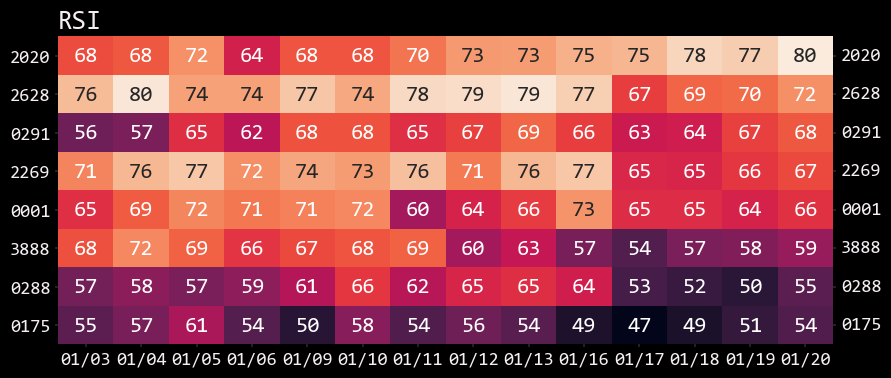

In [6]:
rsi_data = {}
for ticker in tqdm.tqdm((g8_tickers).split('\n')):
    data = get_daily_data_with_today(ticker, datetime.datetime.combine(datetime.date.today(), datetime.time()), enforce_today=True)
    rsi_data[ticker] = RSI(data)
rsi_data = pd.DataFrame(rsi_data)
rsi_data.index = [str(x)[-5:].replace('-', '/') for x in rsi_data.index.date]
rsi_data.columns = [x[4:] for x in rsi_data.columns]

plt.figure(figsize=(10, 4))
ax = sns.heatmap(rsi_data.T.iloc[:, -14:].sort_values(rsi_data.index[-1], ascending=False), annot=True, cbar=False)
ax.tick_params(left=True, labelleft=True, right=True, labelright=True, rotation=0)
plt.title('RSI')
plt.show()

In [12]:
for ticker in tqdm.tqdm((green_tickers + '\n' + blue_tickers).split('\n')):
    df = openbb.stocks.fa.divs(ticker_to_yahoo_format(ticker))
    print(ticker)
    if df.empty:
        continue
    display(df[df.index.tz_localize(None) > datetime.datetime.now() - datetime.timedelta(days=365)])

  0%|                                                    | 0/24 [00:00<?, ?it/s]

HKG:0388


,Dividends,Change
Date,,
2022-08-30 00:00:00+08:00,3.45,-0.73
2022-03-09 00:00:00+08:00,4.18,-0.51


  4%|█▊                                          | 1/24 [00:01<00:23,  1.04s/it]

HKG:3988


,Dividends,Change
Date,,
2022-07-07 00:00:00+08:00,0.258911,0.021268


  8%|███▋                                        | 2/24 [00:01<00:21,  1.02it/s]

HKG:2331


,Dividends,Change
Date,,
2022-06-17 00:00:00+08:00,0.5345,0.2859


 12%|█████▌                                      | 3/24 [00:02<00:20,  1.02it/s]

HKG:0669


,Dividends,Change
Date,,
2022-08-30 00:00:00+08:00,0.95,-0.05
2022-05-18 00:00:00+08:00,1.00,0.15


 17%|███████▎                                    | 4/24 [00:03<00:19,  1.04it/s]

No dividends found.

 21%|█████████▏                                  | 5/24 [00:04<00:16,  1.13it/s]

HKG:9988


No dividends found.

 25%|███████████                                 | 6/24 [00:05<00:14,  1.23it/s]

HKG:2015
HKG:0857


,Dividends,Change
Date,,
2022-09-09 00:00:00+08:00,0.23338,0.12027
2022-06-20 00:00:00+08:00,0.11311,-0.04342


 29%|████████████▊                               | 7/24 [00:06<00:14,  1.15it/s]

HKG:0386


,Dividends,Change
Date,,
2022-09-08 00:00:00+08:00,0.1851,-0.176500
2022-05-31 00:00:00+08:00,0.3616,0.169429


 33%|██████████████▋                             | 8/24 [00:07<00:14,  1.10it/s]

HKG:1088


,Dividends,Change
Date,,
2022-06-29 00:00:00+08:00,3.125,0.967721


 38%|████████████████▌                           | 9/24 [00:08<00:13,  1.09it/s]

HKG:1347


,Dividends,Change
Date,,


 42%|█████████████████▉                         | 10/24 [00:09<00:12,  1.12it/s]

HKG:9999


,Dividends,Change
Date,,
2022-12-01 00:00:00+08:00,0.0870,0.0150
2022-08-31 00:00:00+08:00,0.0720,0.0076
2022-06-07 00:00:00+08:00,0.0644,-0.0166
2022-03-10 00:00:00+08:00,0.0810,0.0360


 46%|███████████████████▋                       | 11/24 [00:09<00:10,  1.18it/s]

HKG:1928


,Dividends,Change
Date,,


 50%|█████████████████████▌                     | 12/24 [00:10<00:10,  1.19it/s]

HKG:1109


,Dividends,Change
Date,,
2022-09-14 00:00:00+08:00,0.208,-1.276
2022-06-20 00:00:00+08:00,1.484,1.276


 54%|███████████████████████▎                   | 13/24 [00:11<00:09,  1.13it/s]

HKG:0939


,Dividends,Change
Date,,
2022-06-29 00:00:00+08:00,0.42595,0.035115


 58%|█████████████████████████                  | 14/24 [00:12<00:09,  1.09it/s]

No dividends found.

 62%|██████████████████████████▉                | 15/24 [00:13<00:07,  1.20it/s]

HKG:9866
HKG:9618


,Dividends,Change
Date,,
2022-05-19 00:00:00+08:00,4.9451,NaN


 67%|████████████████████████████▋              | 16/24 [00:13<00:06,  1.26it/s]

HKG:2688


,Dividends,Change
Date,,
2022-11-03 00:00:00+08:00,0.64,-1.47
2022-05-23 00:00:00+08:00,2.11,1.52


 71%|██████████████████████████████▍            | 17/24 [00:14<00:05,  1.18it/s]

HKG:0992


,Dividends,Change
Date,,
2022-11-25 00:00:00+08:00,0.08,-0.22
2022-08-01 00:00:00+08:00,0.30,0.22


 75%|████████████████████████████████▎          | 18/24 [00:15<00:05,  1.12it/s]

HKG:0268


,Dividends,Change
Date,,


 79%|██████████████████████████████████         | 19/24 [00:16<00:04,  1.11it/s]

HKG:2518


,Dividends,Change
Date,,
2022-03-18 00:00:00+08:00,0.1325,NaN


 83%|███████████████████████████████████▊       | 20/24 [00:17<00:03,  1.11it/s]

No dividends found.

 88%|█████████████████████████████████████▋     | 21/24 [00:18<00:02,  1.20it/s]

HKG:9888


No dividends found.

 92%|███████████████████████████████████████▍   | 22/24 [00:19<00:01,  1.09it/s]

HKG:9626
HKG:0700


,Dividends,Change
Date,,
2022-05-20 00:00:00+08:00,1.6,0.0


 96%|█████████████████████████████████████████▏ | 23/24 [00:20<00:00,  1.08it/s]

HKG:1113


,Dividends,Change
Date,,
2022-09-05 00:00:00+08:00,0.43,-1.36
2022-05-24 00:00:00+08:00,1.79,1.38


100%|███████████████████████████████████████████| 24/24 [00:21<00:00,  1.13it/s]


In [12]:
today = datetime.datetime.combine(datetime.date.today(), datetime.time())
start_date = today - (datetime.timedelta(days=365))
ticker = 'YNDX'
data_until_today = openbb.stocks.load(
    ticker,
    interval=1440,
    start_date=start_date,
    source='EODHD',
    verbose=False
).drop('Adj Close', axis=1)
data_until_today

Invalid API Key for eodhistoricaldata 

Get your Key here: https://eodhistoricaldata.com/r/?ref=869U7F4J

KeyError: "['Adj Close'] not found in axis"